In [92]:
import numpy as np
import matplotlib.pyplot as plt
import csv

### Task 2.1
# Load the source data
Load all the port locations into a numpy array.
Also, set the number of boats, hillclimber iterations and hillclimber repeats.

In [93]:
with open("stops.csv", "r") as srcF:
    ports = np.array(list(csv.reader(srcF, delimiter=",")), dtype=float)

boats = 3
iterations = 500
repeats = 30

# Generate a random solution
Start by generating a random solution.

In [94]:
def gen_random_solution(port_array, boat_count):
    """
    This method takes in the ports and the number of boats and generates a random solution. Ports / Boats must have a remainder of 0.
    :param port_array: A 2d (X, 2) numpy array representing the coordinates of the ports. The first dimension is the port, the second is the X and Y coordinates.
    :param boat_array: The number of boats to use.
    :return: A 2d numpy array (boats, ports/boats) representing each ferry and the ports it visits in order.
    """
    order = np.random.permutation(range(len(port_array))) # randomise the order of the ports
    return order.reshape((boat_count, int(len(order) / boat_count))) # split into supplied number of boats
base_sln = gen_random_solution(ports, boats)

# Create the evaluator and solution visualiser
The evaluator takes in the locations of the ports and the solution and calculates the spatial distance that the solution covers using `scipy.spatial.distance.euclidean`.

The solution visualiser takes in the locations of the ports and the solution and draws it onto a graph.

[[ 5  8  0  6]
 [ 7  9  1  3]
 [ 4 10  2 11]]


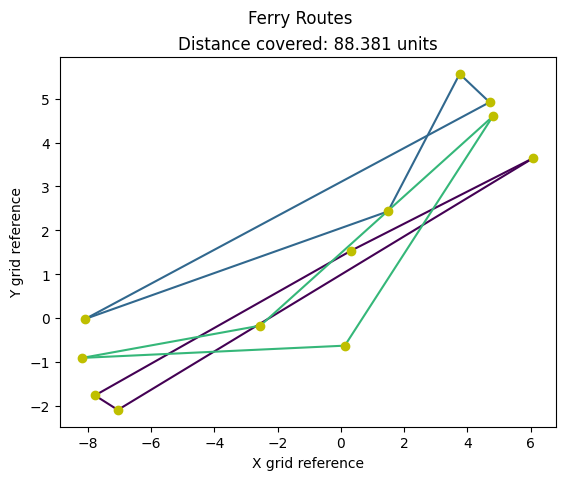

In [95]:
from scipy.spatial.distance import euclidean

def evaluator(solution, ports_array):
    """
    Takes in a solution and calculates the total euclidian distance for the ferry routes.
    :param solution: A 2d numpy array. The first dimension is each ferry, the second is the index of the ports it stops at in the ports array.
    :param ports_array: A 2d (X, 2) numpy array representing the coordinates of the ports. The first dimension is the port, the second is the X and Y coordinates.
    :return: A float representing the total distance the ferries will travel.
    """
    shape = solution.shape
    acc = 0

    for X in range(shape[0]): # for each boat
        for Y in range(shape[1]): # for each stop
            i1, i2 = Y, Y + 1
            if i2 == shape[1]: # at the end of the loop, go back to the first stop
                i2 = 0
            acc += euclidean(ports_array[solution[X][i1]], ports_array[solution[X][i2]]) # add the euclidean distance between the coordinates to the accumulator
    return acc

def graph_routes(solution, ports_array, c_map_name='viridis'):
    """
    This method takes in a solution and plots it on a graph.
    :param solution: A 2d numpy array. The first dimension is each ferry, the second is the index of the ports it stops at in the ports array.
    :param ports_array: A 2d (X, 2) numpy array representing the coordinates of the ports. The first dimension is the port, the second is the X and Y coordinates.
    :param c_map_name: The colour map to use for the graph.
    :return: None
    """
    plt.figure() # separate into its own figure
    shape = solution.shape
    cmap = plt.cm.get_cmap(c_map_name)

    for X in range(shape[0]): # for each boat
        for Y in range(shape[1]): # for each stop
            i1, i2 = Y, Y + 1
            if i2 == shape[1]: # at the end of the loop, go back to the first stop
                i2 = 0
            p1 = ports_array[solution[X][i1]]
            p2 = ports_array[solution[X][i2]]
            c = cmap(X / shape[0]) # evenly distribule route colours across the colour space
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c=c)

    plt.scatter(x=ports_array[:, 0], y=ports_array[:, 1], c="y", zorder=10)

    distance = np.round(evaluator(solution, ports_array), 3) # calculate fitness for the title
    plt.suptitle("Ferry Routes")
    plt.title(f"Distance covered: {str(distance)} units")
    plt.xlabel("X grid reference")
    plt.ylabel("Y grid reference")

print(base_sln)
graph_routes(base_sln, ports)

### Task 2.2
# Create the three optimisers
These are the methods that will mutate the solution.

## Shuffle
This method takes in the solution, picks four contiguous points and randomly shuffles them.

In [96]:
def shuffle(solution, group = 4):
    """
    This mutator selects a random contigious group of (group) points in the solution, shuffles them and returns the solution.
    :param solution: A 2d numpy array. The first dimension is each ferry, the second is the index of the ports it stops at in the ports array.
    :param group: The number of points to include in the shuffle at once. Defaults to four.
    :return: The mutated solution.
    """
    flat = np.ndarray.flatten(solution) # reduce the array to 1d
    index = np.random.randint(len(flat) - (group - 1)) # select an index in the array, making sure there is at least (group - 1) items after
    contigious = flat[index:index + group] # make a contigious selection of points in the selection
    shuffled = np.random.permutation(contigious) # shuffle the selection
    flat[index:index + group] = shuffled # reinsert into array
    return flat.reshape(solution.shape) # reshape the array back into boat routes
print(shuffle(base_sln))

[[ 5  8  0  6]
 [ 7  9  1  3]
 [ 4 11  2 10]]


## Swap
This method takes in the solution, picks two different points and swaps them.

In [97]:
def swap(solution):
    """
    This mutator selects two random points in the solution and swaps them.
    :param solution: A 2d numpy array. The first dimension is each ferry, the second is the index of the ports it stops at in the ports array.
    :return: The mutated solution.
    """
    flat = np.ndarray.flatten(solution) # reduce the array to 1d
    flat_len = len(flat)
    index1 = index2 = np.random.randint(flat_len) # select an index in the array
    while index1 == index2:
        index2 = np.random.randint(flat_len) # select a different index in the array
    flat[index1], flat[index2] = flat[index2], flat[index1] # swap the values at the indexes
    return flat.reshape(solution.shape) # reshape the array back into boat routes
print(swap(base_sln))

[[ 5  8  0  6]
 [ 9  7  1  3]
 [ 4 10  2 11]]


## Ruin and Recreate
This method takes in the solution and creates a novel solution in the same shape.

In [98]:
def ruin_and_recreate(solution):
    """
    This mutator takes the shape of the solution and generates a totally novel solution of the same shape.
    :param solution: A 2d numpy array. The first dimension is each ferry, the second is the index of the ports it stops at in the ports array.
    :return: The new solution.
    """
    length = len(np.ndarray.flatten(solution)) # get the number of ports in the solution
    perm = np.random.permutation(range(length)) # randomise the order of the ports
    return np.reshape(perm, solution.shape) # reshape the array back into boat routes
print(ruin_and_recreate(base_sln))

[[ 8  0  6  3]
 [ 9  1  2  4]
 [10  7 11  5]]


# Create the Hill Climber and the Repeater
The hill climber is the method that will run the mutator and the evaluator and determine if the solution has improved (the distance it covers has decreased). If it has, it will be fed into the mutator in subsequent iterations. At the end, the current solution and its fitness will be returned.

The repeater will run the hill climber multiple times and collect the results. At the end, the fittest solution and the sitness data for all solutions will be returned.

In [99]:
def hill_climber(solution, ports_array, mutator, max_iterations):
    """
    This method repeatedly runs the passed in mutator and the evaluator against the solution. If the mutation had a positive effect (the ferry distance went down) then it is used for each iteration going forward.
    :param solution: The solution to start with. This is a 2d numpy array. The first dimension is each ferry, the second is the index of the ports it stops at in the ports array.
    :param ports_array: A 2d (X, 2) numpy array representing the coordinates of the ports. The first dimension is the port, the second is the X and Y coordinates.
    :param mutator: The mutator to use. This method takes in a solution and returns a modified solution.
    :param max_iterations: The iterations to run the hill climber for
    :return: The final solution as well as the fitness of the solution at each iteration.
    """
    current_distance = evaluator(solution, ports_array) # evaluate the fitness of the starting solution
    distances = [current_distance]
    for _ in range(max_iterations):
        new_solution = mutator(solution) # mutate the solution
        new_distance = evaluator(new_solution, ports_array) # evaluate the fitness of the new solution
        if new_distance < current_distance: # if the solution has improved, keep it and ise it as the benchmark going forward
            solution = new_solution
            current_distance = new_distance
        distances.append(current_distance) # add the fitness value to the list
    return solution, distances

def repeater(base_solution, ports_array, mutator, runs, max_iterations):
    """
    This method repeatedly runs the hill climber.
    :param base_solution: The solution that each solution should start with. The first dimension is each ferry, the second is the index of the ports it stops at in the ports array.
    :param ports_array: A 2d (X, 2) numpy array representing the coordinates of the ports. The first dimension is the port, the second is the X and Y coordinates.
    :param mutator: The mutator should use in the hill climber.
    :param runs: The number of times to run the hill climber
    :param max_iterations: The number of iterations to run the hill climber for
    :return: The fittest solution found across all runs of the hill climber and the fitness data for each iteration of each run.
    """
    solution_acc = []
    fitness_acc = []
    for _ in range(runs):
        solution, fitness = hill_climber(base_solution, ports_array, mutator, max_iterations) # run the hill climber
        solution_acc.append(solution)
        fitness_acc.append(fitness)
    fitness_acc = np.array(fitness_acc)
    model_fitness_order = np.argsort(fitness_acc[:, -1]) # get the fitness order of the outcomes
    return solution_acc[model_fitness_order[0]], fitness_acc # return the fittest solution as well as all the fitness values

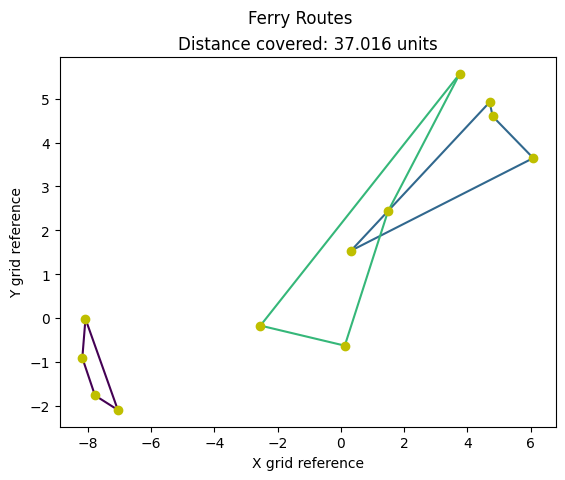

In [100]:
sln, shFitness = repeater(base_sln, ports, shuffle, repeats, iterations)
graph_routes(sln, ports)

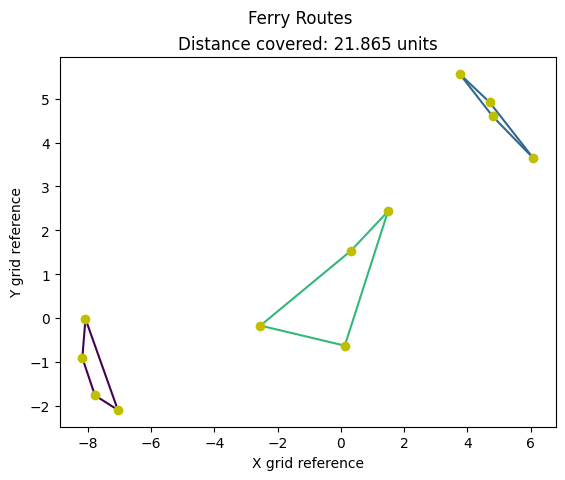

In [101]:
sln, swFitness = repeater(base_sln, ports, swap, repeats, iterations)
graph_routes(sln, ports)

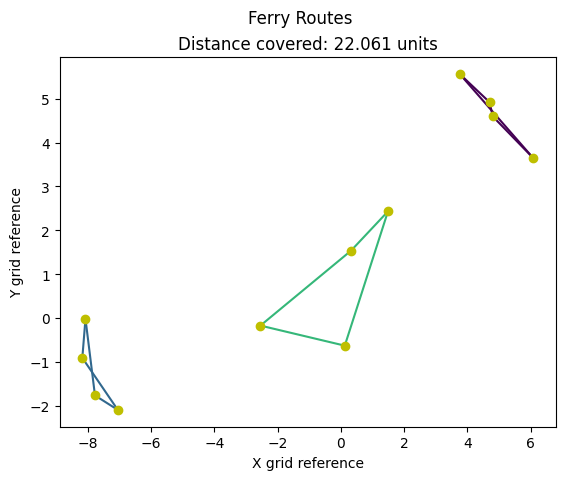

In [102]:
sln, ruFitness = repeater(base_sln, ports, ruin_and_recreate, repeats, iterations)
graph_routes(sln, ports)

### Task 2.3
# Create the fitness visualiser
These graphs represent the minimum, mean and maximum distance each solution covers.

In [103]:
def graph_fitness(shFitnessAcc, swFitnessAcc, ruFitnessAcc, iterations, c_map_name='viridis'):
    """
    This method takes in the fitness data returned from each repeater and graphs their maximum, mean and minimum distance at each iteration.
    :param shFitnessAcc: The fitness data for the repeater run with the shuffle mutator.
    :param swFitnessAcc: The fitness data for the repeater run with the swap mutator.
    :param ruFitnessAcc: The fitness data for the repeater run with the ruin and recreate mutator
    :param iterations: The number of iterations to graph.
    :param c_map_name: The colour map to use for the graph.
    :return: None
    """
    cmap = plt.cm.get_cmap(c_map_name)
    shMaxAcc, shMinAcc, shMeanAcc = [], [], []
    swMaxAcc, swMinAcc, swMeanAcc = [], [], []
    ruMaxAcc, ruMinAcc, ruMeanAcc = [], [], []

    for X in range(iterations):
        shMaxAcc.append(max(shFitnessAcc[:, X]))
        shMinAcc.append(min(shFitnessAcc[:, X]))
        shMeanAcc.append(np.mean(shFitnessAcc[:, X]))

        swMaxAcc.append(max(swFitnessAcc[:, X]))
        swMinAcc.append(min(swFitnessAcc[:, X]))
        swMeanAcc.append(np.mean(swFitnessAcc[:, X]))

        ruMaxAcc.append(max(ruFitnessAcc[:, X]))
        ruMinAcc.append(min(ruFitnessAcc[:, X]))
        ruMeanAcc.append(np.mean(ruFitnessAcc[:, X]))

    for X in [
        ["Maximum", shMaxAcc, swMaxAcc, ruMaxAcc],
        ["Mean", shMeanAcc, swMeanAcc, ruMeanAcc],
        ["Minimum", shMinAcc, swMinAcc, ruMinAcc]]:
        plt.figure()
        plt.title(f"{X[0]} Distance over Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Distance (Lower is better)")
        plt.plot(X[1], c=cmap(0))
        plt.plot(X[2], c=cmap(0.5))
        plt.plot(X[3], c=cmap(0.99))
        plt.legend([f"Shuffle {X[0]} Distance", f"Swap {X[0]} Distance", f"Ruin & Repeat {X[0]} Distance"])
    
    plt.figure()
    plt.title(f"Combined graph of Distance over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Distance (Lower is better)")
    for X in [shMaxAcc, shMinAcc, shMeanAcc, swMaxAcc, swMinAcc, swMeanAcc, ruMaxAcc, ruMinAcc, ruMeanAcc]:
        plt.plot(X)
    plt.legend(["Shuffle Maximum Distance", "Shuffle Minimum Distance", "Shuffle Mean Distance",
    "Swap Maximum Distance", "Swap Minimum Distance", "Swap Mean Distance",
    "Ruin & Repeat Maximum Distance", "Ruin & Repeat Minimum Distance", "Ruin & Repeat Mean Distance"], bbox_to_anchor=(1.05, 1.0), loc='upper left')

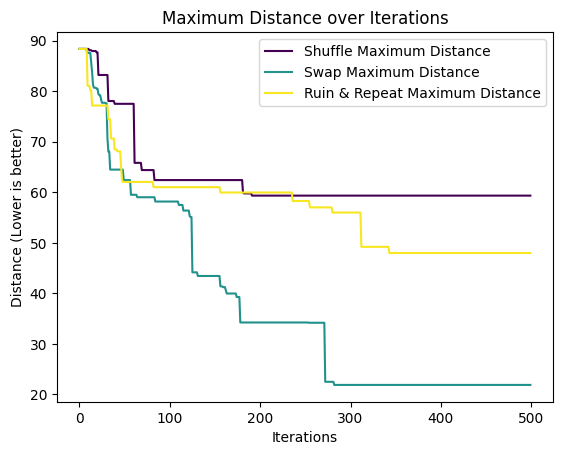

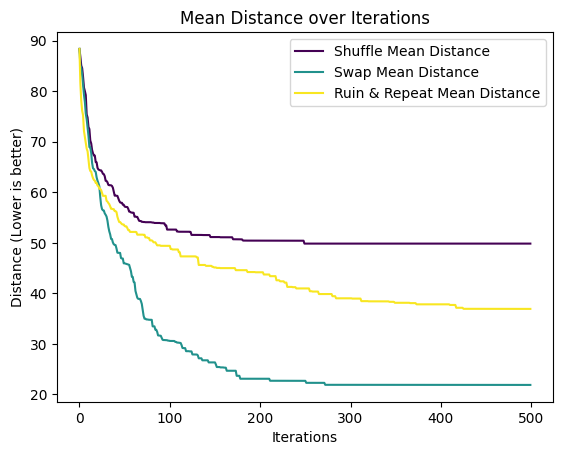

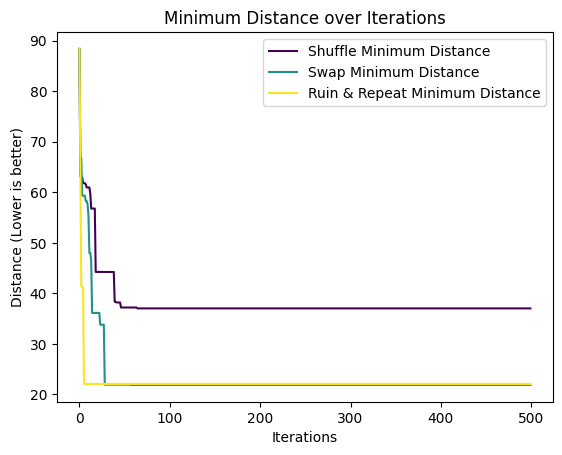

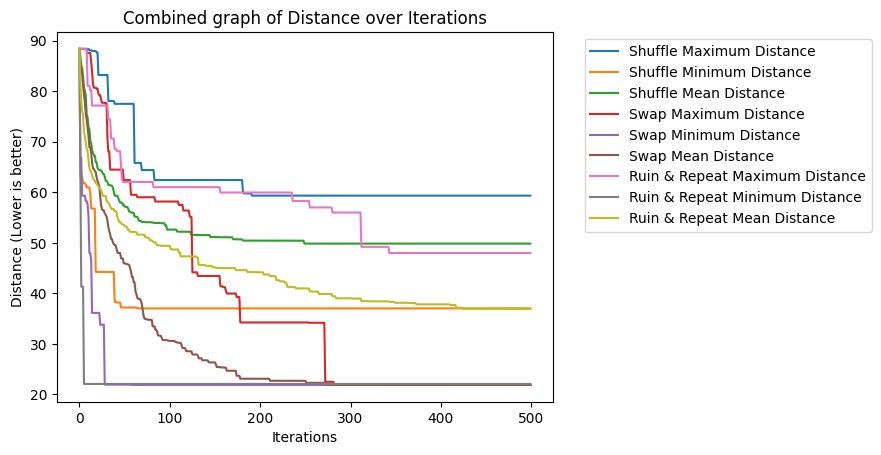

In [104]:
graph_fitness(shFitness, swFitness, ruFitness, iterations)

# Conclusion
In Conclusion, the swap function appears to be the best mutator for this problem followed by ruin and repeat and finally shuffle. This is because in the average (mean) run, swap was able to reach a more optimal solution with a distance of around 22 whereas ruin and repeat and shuffle have significantly higher mean distances of between 40 and 60 depending on run.

Having said this, I believe that if this problem were to scale up, these outcomes are likely to change and that a combination of swap and shuffle would be optimal. This is because as more ports are added, the likelihood of swap finding 2 ports that are beneficial to change would decrease whereas the more constrained changes of shuffle could prove more beneficial. The reason I think that shuffle did not come out on top in this case is that it struggles escaping local minima by itself. for example, to move a port from route 1 to route 3 would require at least two beneficial shuffles together. Using it in conjunction with a more drastic mutator would help to alleviate this problem. Additionally, using a genetic population and cross mutations would also be more likely to land on a optimal solution faster than this standalone solution.